In [2]:
import os
os.chdir('/Users/haozheshan/Dropbox/codes/gp_continual_learning/')
import numpy as np
import matplotlib.pyplot as plt
import theory, cluster_utils, torch, data, utils, tqdm, scipy.optimize

%load_ext autoreload
%autoreload 2

# USE KEYWORDS BELOW TO SEARCH FOR FOLDERS
batch_name_list =cluster_utils.list_folders('cluster_results/', 'mnist', '100')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating a list at 2023-05-26 16:05
[0] gp_100x500_mnist_permuted_diff_depth_naiveGP
[1] gradient_20x500_mnist_permuted_3L_N1000_MINI1_eta1
[2] gp_100x500_mnist_permuted_diff_depth
[3] gradient_20x500_mnist_permuted_1L_N1000_MINI1_eta1
[4] gradient_20x500_mnist_permuted_3L_N1000_MINI1_eta2
[5] gradient_20x500_mnist_permuted_1L_N1000_MINI1_eta0p5
[6] gradient_20x500_mnist_permuted_3L_N1000_MINI1_eta0p5
[7] gradient_20x500_mnist_permuted_1L_N1000_MINI1_eta2


In [34]:
folder_index = 2
sort_by_key = 'depth'
organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name=batch_name_list[folder_index], sort_by_key=sort_by_key)

all_test_loss = organizer.organize_results('test loss')
all_train_loss = organizer.organize_results('train loss')
all_nn_preds = organizer.organize_results('sampled outputs')

all_train_mag = organizer.organize_results('train magnitude')

args = organizer.args
print(args)

folder_index = 0
sort_by_key = 'depth'
organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name=batch_name_list[folder_index], sort_by_key=sort_by_key)

all_test_loss2 = organizer.organize_results('test loss')
all_train_loss2 = organizer.organize_results('train loss')
all_nn_preds = organizer.organize_results('sampled outputs')

all_train_mag2 = organizer.organize_results('train magnitude')

args = organizer.args
print(args)

=================== Cluster organizer ===================
500 data objects loaded from folder "gp_100x500_mnist_permuted_diff_depth".
For key <<depth>>, the values are [1, 3, 7, 9, 5]
=================== Cluster organizer ===================
Available data keys are dict_keys(['args', 'train loss', 'test loss', 'train acc', 'test acc', 'train magnitude', 'Vt_Sigma1_Vt', 'V1_Sigma1_Vt', 'V1_V1', 'tr(P1P2)/P'])
Organizer: data with key <<sampled outputs>> were not found
Namespace(f=None, cluster=1, BATCH_NAME='gp_100x500_mnist_permuted_diff_depth', TRIAL_IND=43, P=500, P_test=50, n_tasks=100, T=0.0, sigma=0.2, permutation=1.0, resample=0, depth=1, seed=44, lambda_val=100000.0, task_type='permuted', naive_gp=0, dataset='mnist', N0context=0, context_strength=1.0, save_outputs=0, data_seed=44)
=================== Cluster organizer ===================
500 data objects loaded from folder "gp_100x500_mnist_permuted_diff_depth_naiveGP".
For key <<depth>>, the values are [3, 1, 7, 9, 5]
=========

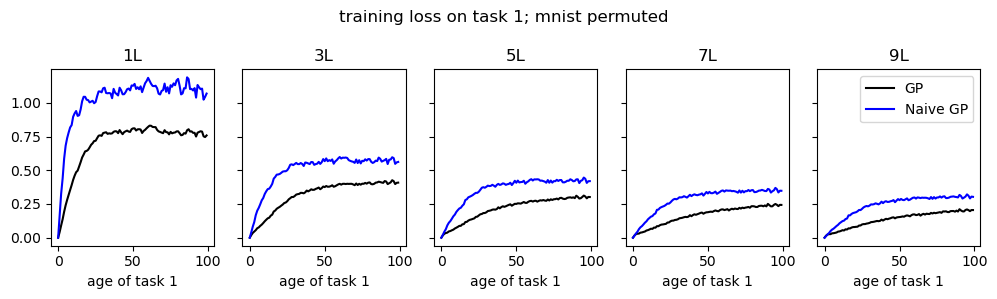

In [35]:

xaxis = np.arange(100)
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(10, 3), sharey=True)

m_asympt1s = []
m_asympt2s = []
m_tau1s = []
m_tau2s = []

a_asympt1s = []
a_asympt2s = []
a_tau1s = []
a_tau2s = []


for i, depth_key in enumerate(['1', '3', '5', '7', '9']):

    loss1 = all_train_loss[depth_key].mean(0)[0, ]
    loss2 = all_train_loss2[depth_key].mean(0)[0, ]

    plt.sca(axes[i])
    plt.title(f'{depth_key}' +'L')
    # plt.plot(1 - loss1 / (loss2 + 1e-10))
    plt.plot(loss1, color='k')
    plt.plot(loss2, color='b')
    plt.xlabel('age of task 1')


    mag1 = all_train_mag[depth_key].mean(0)[0, ]
    mag2 = all_train_mag2[depth_key].mean(0)[0, ]
    m_asympt1, m_tau1, mag1_fit = utils.exponential_fit(xaxis, mag1, plot_axis=np.arange(200))
    m_asympt2, m_tau2, mag2_fit = utils.exponential_fit(xaxis, mag2, plot_axis=np.arange(200))
    a_asympt1, a_tau1, align1_fit = utils.exponential_fit(xaxis, -0.5 * (loss1 - mag1 - 1), plot_axis=np.arange(200))
    a_asympt2, a_tau2, align2_fit = utils.exponential_fit(xaxis, -0.5 * (loss2 - mag2 - 1), plot_axis=np.arange(200))
    # plt.plot(mag1_fit + 1 - 2 * align1_fit, color='k', ls=linestyles[i], label=f'{depth_key}' +'L')
    # plt.plot(mag2_fit + 1 - 2 * align2_fit, color='b', ls=linestyles[i], label=f'{depth_key}' +'L naive')
    # plt.scatter(xaxis, loss1, color='k')
    # plt.scatter(xaxis, loss2, color='b')

    m_asympt1s.append(m_asympt1)
    m_asympt2s.append(m_asympt2)
    a_asympt1s.append(a_asympt1)
    a_asympt2s.append(a_asympt2)

    m_tau1s.append(m_tau1)
    m_tau2s.append(m_tau2)
    a_tau1s.append(a_tau1)
    a_tau2s.append(a_tau2)
plt.legend(['GP', 'Naive GP'])

plt.suptitle(f'training loss on task 1; {organizer.args.dataset} {organizer.args.task_type}')
plt.tight_layout()


## Plot long-term-forgetting fit parameters as a function of depth

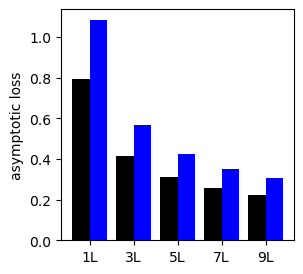

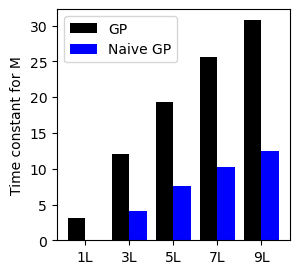

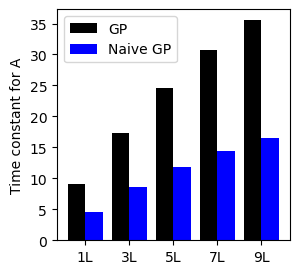

In [40]:
plt.figure(figsize=(3, 3))
plt.bar(np.arange(5), np.array(m_asympt1s) + 1 - 2 * np.array(a_asympt1s), color='k', width=0.4)
plt.bar(np.arange(5) + 0.4, np.array(m_asympt2s) + 1 - 2 * np.array(a_asympt2s), color='b', width=0.4)
plt.xticks(np.arange(5) + 0.2, ['1L', '3L', '5L', '7L', '9L'])
plt.ylabel('asymptotic loss')


plt.figure(figsize=(3, 3))
plt.bar(np.arange(5), m_tau1s, color='k', width=0.4)
plt.bar(np.arange(5) + 0.4, m_tau2s, color='b', width=0.4)
plt.xticks(np.arange(5) + 0.2, ['1L', '3L', '5L', '7L', '9L'])
plt.ylabel('Time constant for M')
plt.legend(['GP', 'Naive GP'])


plt.figure(figsize=(3, 3))
plt.bar(np.arange(5), a_tau1s, color='k', width=0.4)
plt.bar(np.arange(5) + 0.4, a_tau2s, color='b', width=0.4)
plt.xticks(np.arange(5) + 0.2, ['1L', '3L', '5L', '7L', '9L'])
plt.ylabel('Time constant for A')
plt.legend(['GP', 'Naive GP'])

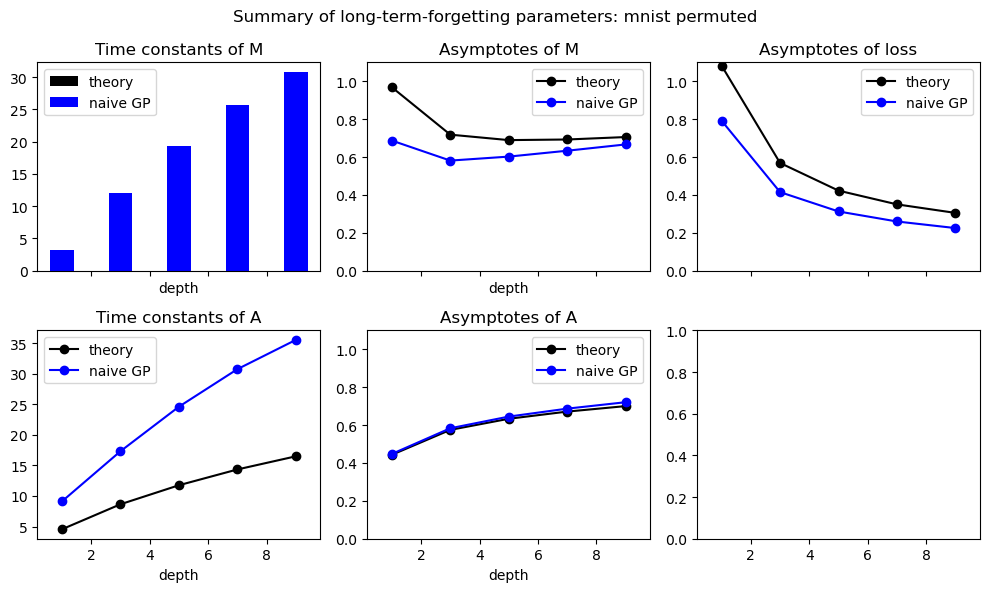

In [25]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharex=True)
axes = axes.ravel()
plt.sca(axes[0])
plt.bar([1, 3, 5, 7, 9], m_tau1s, color='k', label='theory')
plt.bar([1, 3, 5, 7, 9], m_tau2s, color='b', label='naive GP')
plt.title('Time constants of M')
plt.xlabel('depth')
plt.legend()

plt.sca(axes[3])
plt.plot([1, 3, 5, 7, 9], a_tau1s, color='k', label='theory', marker='o')
plt.plot([1, 3, 5, 7, 9], a_tau2s, color='b', label='naive GP', marker='o')
plt.title('Time constants of A')
plt.xlabel('depth')
plt.legend()

plt.sca(axes[1])
plt.plot([1, 3, 5, 7, 9], m_asympt1s, color='k', label='theory', marker='o')
plt.plot([1, 3, 5, 7, 9], m_asympt2s, color='b', label='naive GP', marker='o')
plt.title('Asymptotes of M')
plt.xlabel('depth')
plt.ylim(0, 1.1)
plt.legend()

plt.sca(axes[4])
plt.plot([1, 3, 5, 7, 9], a_asympt1s, color='k', label='theory', marker='o')
plt.plot([1, 3, 5, 7, 9], a_asympt2s, color='b', label='naive GP', marker='o')
plt.title('Asymptotes of A')
plt.xlabel('depth')
plt.ylim(0, 1.1)
plt.legend()

plt.sca(axes[2])
plt.plot([1, 3, 5, 7, 9], 1 + np.array(m_asympt1s) - 2 * np.array(a_asympt1s), color='k', label='theory', marker='o')
plt.plot([1, 3, 5, 7, 9], 1 + np.array(m_asympt2s) - 2 * np.array(a_asympt2s), color='b', label='naive GP', marker='o')
plt.title('Asymptotes of loss')
plt.ylim(0, 1.1)
plt.legend()

plt.suptitle('Summary of long-term-forgetting parameters: ' + organizer.args.dataset + ' ' + organizer.args.task_type)

plt.tight_layout()

Text(0.5, 1.0, 'training loss on task 1 after learning task 2')

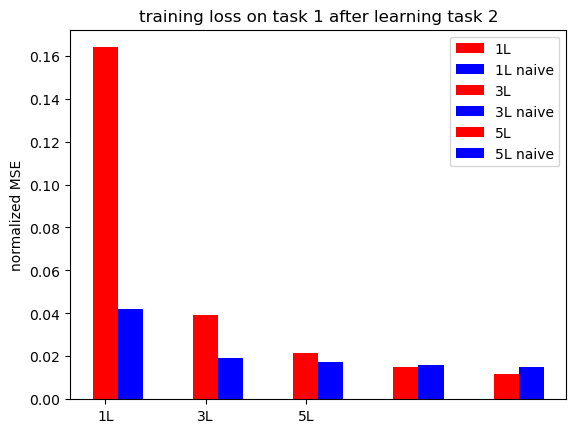

In [17]:
plt.figure()
for i, key in enumerate(['1', '3', '5', '7', '9']):
    plt.bar(i*2, all_train_loss[key].mean(0)[0, 1], color='r', width=0.5)
    plt.bar(i*2+0.5, all_train_loss2[key].mean(0)[0, 1], color='b', width=0.5)
plt.legend(['1L', '1L naive', '3L', '3L naive', '5L', '5L naive'])
plt.ylabel('normalized MSE')
plt.xticks([0, 2, 4], ['1L', '3L', '5L'])
plt.title('training loss on task 1 after learning task 2')

## TEMP: debugging